In [1]:
import osmnx as ox

ox.config(log_console = True, data_folder = 'data')
graph = ox.load_graphml('northeuroperails_alt.graphml')

In [18]:
import networkx as nx

hki = ox.truncate_graph_bbox(graph, 60.308, 60.151, 25.243, 24.704, retain_all=True)
hki = hki.to_undirected()

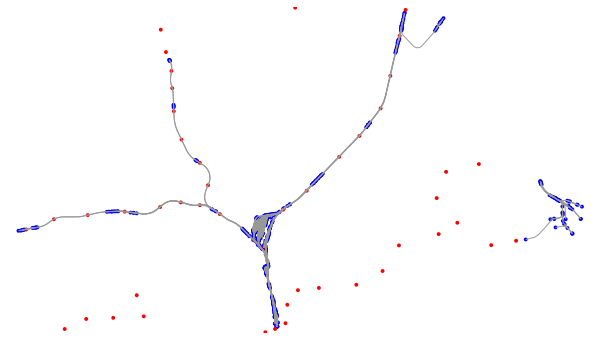

(<Figure size 1563.34x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22b6a6e1340>)

In [82]:
node_colors = ['r' if 'railway' in d and d['railway'] == 'station' else 'b' for d in hki.nodes.values()]
ox.plot_graph(hki, node_color = node_colors)

In [68]:
hki.nodes[25710227]

{'y': 60.2624633,
 'x': 25.0285605,
 'osmid': 25710227,
 'railway': 'station',
 'name': 'Tapanila'}

In [86]:
ox.get_nearest_edge(hki, (60.22208, 24.87665))

(<shapely.geometry.linestring.LineString at 0x22b3938d370>,
 339826323,
 339854939)

In [87]:
hki[339826323][339854939]

AtlasView({0: {'osmid': [389604321, 321206408, 389604309, 30728254, 389604313, 389604314, 30728603, 389604317, 30728606], 'maxspeed': ['110', '80'], 'name': 'Leppävaaran kaupunkirata', 'oneway': False, 'length': 4110.2609999999995, 'bridge': 'yes', 'geometry': <shapely.geometry.linestring.LineString object at 0x0000022B3938D370>}})

In [3]:
import numpy as np
stations = np.array(
    [[k, v['x'], v['y']] for k, v in hki.nodes.items() if 'railway' in v and v['railway'] == 'station']
)
nearest = ox.get_nearest_edges(hki, stations[:, 1], stations[:, 2])

In [4]:
import numpy.linalg as npl

def is_point_on_edge(graph, edge, point, treshold):
    edge_start = graph.nodes[edge[0]]
    edge_end = graph.nodes[edge[1]]
    a = np.array([edge_end['x'] - edge_start['x'], edge_end['y'] - edge_start['y']])
    edge_len = npl.norm(a)
    a /= edge_len
    b = np.array([- a[1] / a[0], 1])
    b /= npl.norm(b)
    
    x = np.array([point[0] - edge_start['x'], point[1] - edge_start['y']])
    beta = (x[1]*a[0] - x[0]*a[1]) / (a[0]*b[1] - b[0]*a[1])
    if np.abs(beta) > treshold: return False
    alpha = (x[0] - beta * b[0]) / a[0]
    return alpha > 0 and alpha < edge_len

is_on_edge = {int(k): is_point_on_edge(hki, e, p, .01) for k, e, p in zip(stations[:, 0], nearest, stations[:, 1:])}
is_on_edge

{25474663: True,
 25477046: True,
 25710227: True,
 25710228: True,
 26432517: True,
 50818752: False,
 51074268: False,
 51334955: False,
 51335241: False,
 51425628: False,
 52607942: False,
 52609066: False,
 53834249: True,
 59594747: False,
 60289871: True,
 76388216: True,
 92560933: True,
 92567667: True,
 117926288: True,
 146450892: False,
 178275725: True,
 339605265: True,
 339833223: True,
 339835310: True,
 339840474: True,
 339842372: True,
 339842947: True,
 339848672: True,
 339850922: True,
 339856183: True,
 339861453: True,
 340019021: True,
 340021461: False,
 392940601: False,
 417945641: False,
 418089193: False,
 418089197: False,
 418089202: False,
 418089207: False,
 1041864527: False,
 1378007268: False,
 1516867775: True,
 2177226631: False,
 4248989440: True,
 4364527726: False,
 4364527727: False,
 4364527728: False,
 4364527729: False,
 4364527730: False,
 4364527731: False,
 4364527732: False,
 4364527733: False,
 4575281541: False,
 5421817304: False}

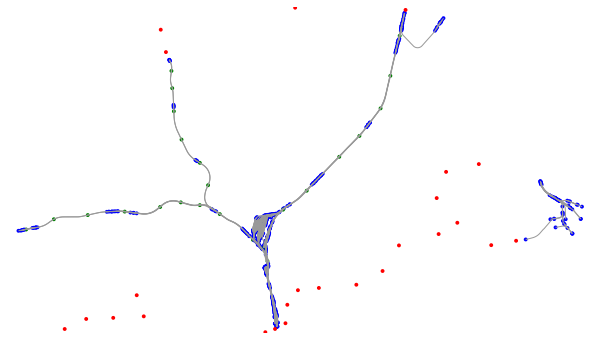

(<Figure size 1563.34x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22b4ad27a00>)

In [74]:
import networkx as nx

nx.set_node_attributes(hki, is_on_edge, 'is_on_edge')

def on_edge_node_color(n):
    if 'railway' not in n or n['railway'] != 'station':
        return 'b'
    if 'is_on_edge' not in n:
        return 'y'
    return 'g' if n['is_on_edge'] else 'r'

node_colors = [on_edge_node_color(d) for d in hki.nodes.values()]
ox.plot_graph(hki, node_color = node_colors)

In [4]:
hki[340018966]

AdjacencyView({340018968: {0: {'osmid': 30743883, 'maxspeed': '80', 'service': 'crossover', 'oneway': False, 'length': 67.985}}, 279995238: {0: {'osmid': 401430302, 'maxspeed': '80', 'name': 'Keravan kaupunkirata', 'oneway': False, 'length': 341.304, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000022B1C0334F0>}}, 1650982161: {0: {'osmid': [25683049, 401430298, 25682061, 464232240, 401430289, 25682066, 401430288, 401430266, 401430299, 25682332, 401430301, 401430302], 'maxspeed': ['80', '120'], 'name': 'Keravan kaupunkirata', 'oneway': False, 'length': 3582.213, 'bridge': 'yes', 'geometry': <shapely.geometry.linestring.LineString object at 0x0000022B1C031F40>}}})

In [14]:
import shapely.geometry as shg

# This method is modified get_nearest_edges method from osmnx (https://github.com/gboeing/osmnx)
def iter_nearest_edges(G, point):
    """
    Return the nearest edge to a pair of coordinates. Pass in a graph and a tuple
    with the coordinates. We first get all the edges in the graph. Secondly we compute
    the euclidean distance from the coordinates to the segments determined by each edge.
    The last step is to sort the edge segments in ascending order based on the distance
    from the coordinates to the edge. In the end, the first element in the list of edges
    will be the closest edge that we will return as a tuple containing the shapely
    geometry and the u, v nodes.
    Parameters
    ----------
    G : networkx multidigraph
    point : tuple
        The (lat, lng) or (y, x) point for which we will find the nearest edge
        in the graph
    Returns
    -------
    closest_edge_to_point : tuple (shapely.geometry, u, v)
        A geometry object representing the segment and the coordinates of the two
        nodes that determine the edge section, u and v, the OSM ids of the nodes.
    """
    gdf = ox.graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)
    graph_edges = gdf[["geometry", "u", "v"]].values.tolist()

    edges_with_distances = [
        (
            graph_edge,
            shg.Point(tuple(reversed(point))).distance(graph_edge[0])
        )
        for graph_edge in graph_edges
    ]

    edges_with_distances = sorted(edges_with_distances, key=lambda x: x[1])
    for e in edges_with_distances:
        _, u, v = e[0]
        yield u, v

In [19]:
from itertools import combinations
from scipy.spatial.distance import euclidean

def erase_node(graph, node):
    lengths = {}
    edges_to_remove = []
    for adjacent, edges in graph[node].items():
        for eid, edata in edges.items():
            if adjacent in lengths:
                lengths[adjacent] = min(lengths[adjacent], edata['length'])
            else:
                lengths[adjacent] = edata['length']
            edges_to_remove.append((node, adjacent, eid))
    for e in edges_to_remove:
        graph.remove_edge(*e)
    for f, t in combinations(lengths, 2):
        graph.add_edge(f, t, length = lengths[f] + lengths[t])

def rewire_edge(graph, edge, node):
    edge_length = min(e['length'] for e in graph[edge[0]][edge[1]].values())
    edges_to_remove = []
    for e in graph[edge[0]][edge[1]]:
        edges_to_remove.append((edge[0], edge[1], e))
    for e in edges_to_remove:
        graph.remove_edge(*e)
    p1 = (graph.nodes[edge[0]]['x'], graph.nodes[edge[0]]['y'])
    p2 = (graph.nodes[edge[1]]['x'], graph.nodes[edge[1]]['y'])
    pn = (graph.nodes[node]['x'], graph.nodes[node]['y'])
    dist1 = euclidean(p1, pn)
    dist2 = euclidean(p2, pn)
    total_dist = dist1 + dist2
    frac1 = dist1 / total_dist
    frac2 = dist2 / total_dist
    graph.add_edge(edge[0], node, length = edge_length * frac1)
    graph.add_edge(edge[1], node, length = edge_length * frac2)

nodes_to_remove = []
for n, d in hki.nodes.items():
    if 'railway' in d and d['railway'] == 'station':
        if hki.degree[n] > 0:
            continue
        p = (d['y'], d['x'])
        nearest_iterator = iter_nearest_edges(hki, p)
        nearest_edge = next(nearest_iterator)
        if not is_point_on_edge(hki, (nearest_edge[0], nearest_edge[1]), (d['x'], d['y']), .01):
            erase_node(hki, n)
            nodes_to_remove.append(n)
        else:
            while is_point_on_edge(hki, (nearest_edge[0], nearest_edge[1]), (d['x'], d['y']), .01):
                rewire_edge(hki,(nearest_edge[0], nearest_edge[1]), n)
                nearest_edge = next(nearest_iterator)
                while nearest_edge not in hki.edges:
                    nearest_edge = next(nearest_iterator)

for n in nodes_to_remove:
    hki.remove_node(n)

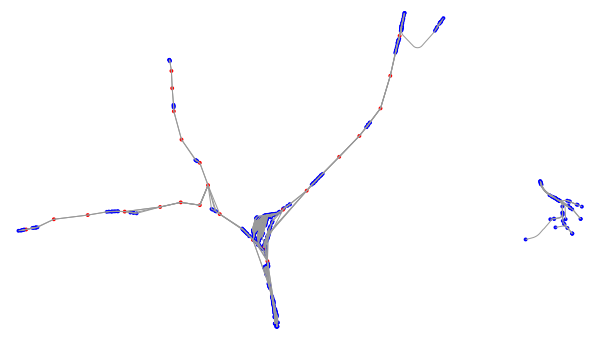

AdjacencyView({339856176: {0: {'osmid': 30728606, 'maxspeed': '110', 'name': 'Leppävaaran kaupunkirata', 'oneway': False, 'length': 13.697}}, 339854941: {0: {'osmid': 30728921, 'maxspeed': '80', 'service': 'crossover', 'oneway': False, 'length': 137.244, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000024B848EFFD0>}}, 339850922: {0: {'length': 1315.3603776620905}}})

In [20]:
node_colors = ['r' if 'railway' in d and d['railway'] == 'station' else 'b' for d in hki.nodes.values()]
ox.plot_graph(hki, node_color = node_colors)
hki[339854939]

In [21]:
nodes_to_remove = []
for n, d in hki.nodes.items():
    if 'railway' not in d or d['railway'] != 'station':
        erase_node(hki, n)
        nodes_to_remove.append(n)

for n in nodes_to_remove:
    hki.remove_node(n)

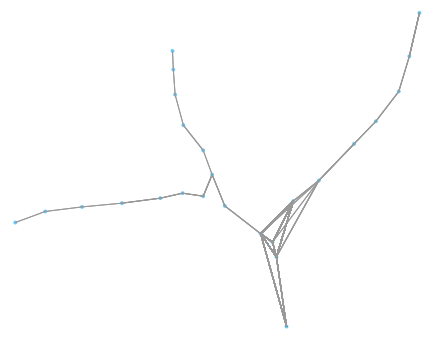

(<Figure size 1121.34x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x24b986736a0>)

In [22]:
ox.plot_graph(hki)